# About this notebook

This Jupyter notebook performs a comprehensive analysis of text classification on the Yelp review dataset using both traditional machine learning and Transformers. Here are some key points covered in the notebook:

- __Baseline Model with Naive Bayes__: The notebook begins by creating a baseline model using Naive Bayes, a traditional machine learning algorithm frequently used for text classification tasks. This model serves as a benchmark for evaluating the performance of subsequent models.

- __TextClassifier for Transformer Models__: The notebook then utilizes the TextClassifier class to evaluate the performance of various Transformer models on the Yelp review  dataset "out-of-the-box" without any fine-tuning. This allows for an understanding of how well these pre-trained models perform on the task right away.

- __Fine-Tuning RoBERTa-base__: The notebook then fine-tunes the RoBERTa-base model. Fine-tuning involves training the pre-existing model on the Yelp review dataset, allowing the model to specialize its knowledge towards the text classification task at hand.

- __Evaluation__: Lastly, we evaluate and compare the results from the fine-tuned RoBERTa model against the baseline Naive Bayes model and the initial out-of-the-box Transformer models' performance. This comparison is performed using a confusion matrix created from a classification report from the `sklearn` library, with a particular focus on the weighted F1-score and accuracy as key performance metrics. This detailed comparison provides insight into how much improvement the fine-tuning process brought about, and the relative strengths and weaknesses of each model for this particular task.


# Imports

In [ ]:
# Load setup.py file
%load ../utils/setup.py
%run ../utils/setup.py

In [ ]:
# Load utils.py file
%load ../utils/utils.py
%run ../utils/utils.py

In [ ]:
# Load plotting.py file
%load ../utils/plotting.py
%run ../utils/plotting.py

In [ ]:
useGPU()

Have fun with this chapter!🥳


# Allocate enough RAM

Let us try to get a __GPU__ with at least __15GB RAM__ for our notebook.

In [ ]:
# crash colab to get more RAM -> uncomment to use
#!kill -9 -1

We can execute the following command `!free -h`  to see if we have enough RAM and `!nvidia-smi` to get more info about our GPU type we got assigned.
If the allocated GPU is too small, the above cell can be used to run the command to crash the notebook hoping to get a better GPU after the crash, since the GPU is randomly allocated.


In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           51Gi       1.3Gi        45Gi       2.0Mi       4.5Gi        49Gi
Swap:            0B          0B          0B


In [ ]:
!nvidia-smi

Mon May  8 03:02:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

if torch.cuda.is_available():
    gpu_device = torch.device('cuda')
    gpu_info = torch.cuda.get_device_properties(gpu_device)
    gpu_memory = gpu_info.total_memory / 1e9  # Convert bytes to gigabytes
    print(f"GPU: {gpu_info.name}, Total Memory: {gpu_memory:.2f} GB")
else:
    print("No GPU detected.")


GPU: Tesla V100-SXM2-16GB, Total Memory: 16.94 GB


# Imports

In [ ]:
# Basic imports
import numpy as np  
import pandas as pd
from datasets import load_dataset

# Torch imports
from torch.utils.data import Dataset  

# Transformers imports
from transformers import (EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, 
                          BertForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification, 
                          RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments) 

# Evaluation imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import evaluate  # Evaluation script from Hugging Face

# Visualization imports
import matplotlib.pyplot as plt  

# Miscellaneous imports 
import random  
import warnings  

# Suppress warnings related to undefined metrics in classification reports
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Suppress logging messages from the transformers library
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


## Set seed function

The `set_seed` function sets the seed for various random number generators used in the notebook to ensure that the results are reproducible. It first sets the seed for `numpy` and `torch`. If a GPU is available, it then sets the seed for all `cuda` operations and ensures that the results are deterministic.

Setting the seed is important when working with random processes in order to ensure that the results are consistent between runs. This is especially important when training machine learning models, as different random seeds can result in different model performance.

In [ ]:
set_seed()

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# News classification

In [ ]:
dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

✅ Evaluating BERT...


✅ Evaluating RoBERTa...


✅ Evaluating DistilBERT...


✅ Evaluating DeBERTa...


✅ Evaluating ALBERT...


✅ Evaluating ELECTRA...


            Accuracy  F1 Score  1-Star F1  2-Star F1  3-Star F1
4-Star F1  \
Model
BERT            0.27  0.151779   0.424779   0.060606   0.000000
0.148148
RoBERTa         0.24  0.092903   0.387097   0.000000   0.000000
0.000000
DistilBERT      0.14  0.050724   0.000000   0.068966   0.000000
0.000000
DeBERTa         0.14  0.034386   0.000000   0.000000   0.000000
0.000000
ALBERT          0.23  0.101684   0.000000   0.000000   0.105263
0.382609
ELECTRA         0.21  0.091636   0.381818   0.000000   0.000000
0.000000

            5-Star F1
Model
BERT         0.000000
RoBERTa      0.000000
DistilBERT   0.234234
DeBERTa      0.245614
ALBERT       0.000000
ELECTRA      0.000000


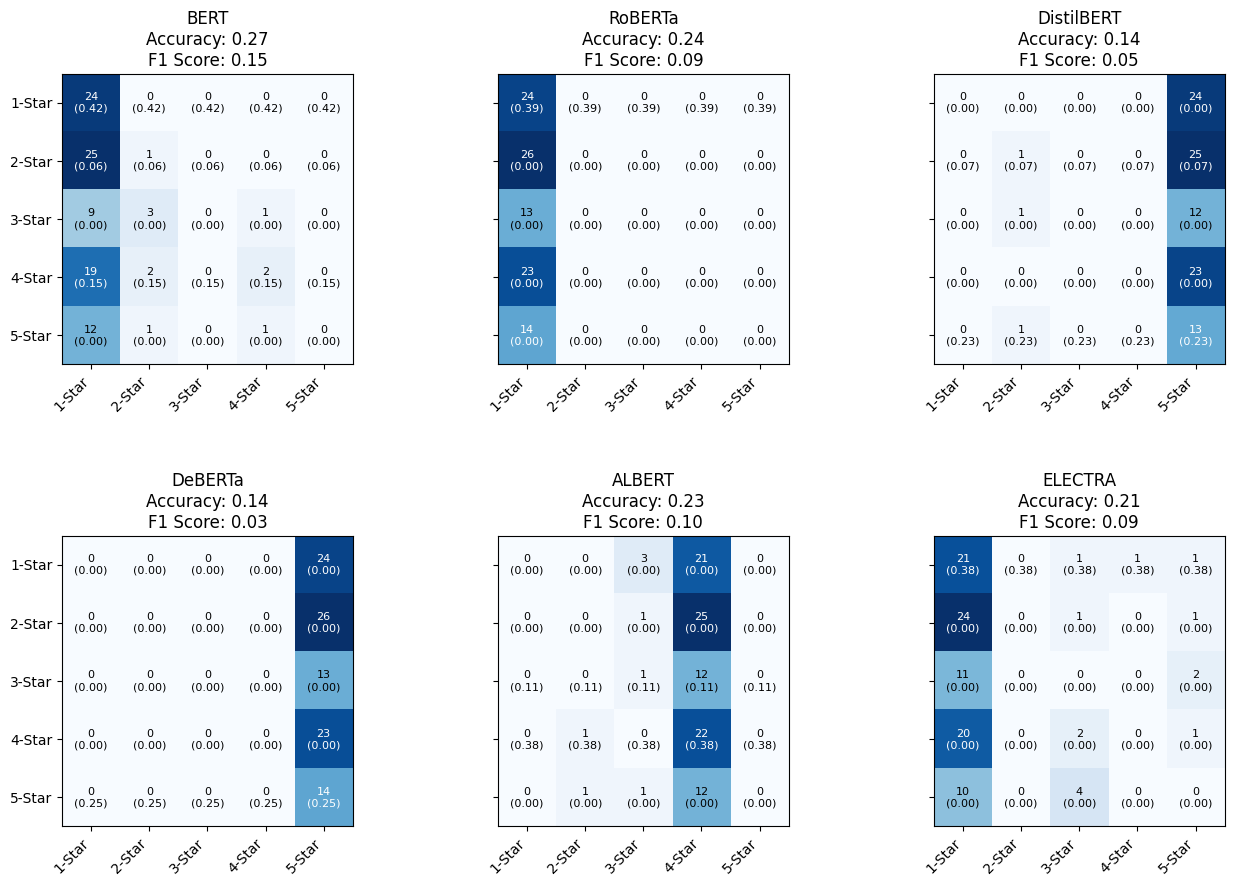

In [ ]:
models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased",
    "DeBERTa": "microsoft/deberta-base",
    "ALBERT": "albert-base-v2",
    "ELECTRA": "google/electra-base-discriminator",
}

yelp_target_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
yelp_classifier = TextClassifier(dataset["test"], models, yelp_target_names)
evaluation_df_yelp_before = yelp_classifier.evaluate_models(num_columns=3, figsize=(15, 10))

## Reduce and split dataset

In [ ]:
train_fraction = 0.02
val_fraction = 0.01
test_fraction = 1000 / len(dataset['test'])

yelp_train, yelp_val, _ = reduce_dataset_size_and_split(dataset['train'], train_fraction=train_fraction, val_fraction=val_fraction)
_, _, yelp_test = reduce_dataset_size_and_split(dataset['test'], train_fraction=1-test_fraction, val_fraction=0, test_fraction=test_fraction)

print(f"Train dataset size: {len(yelp_train)}")
print(f"Validation dataset size: {len(yelp_val)}")
print(f"Test dataset size: {len(yelp_test)}")


Train dataset size: 13000
Validation dataset size: 6500
Test dataset size: 1000


## Plot data distribution

In [ ]:
yelp_train_df = pd.DataFrame(yelp_train)
yelp_val_df = pd.DataFrame(yelp_val)
yelp_test_df = pd.DataFrame(yelp_test)


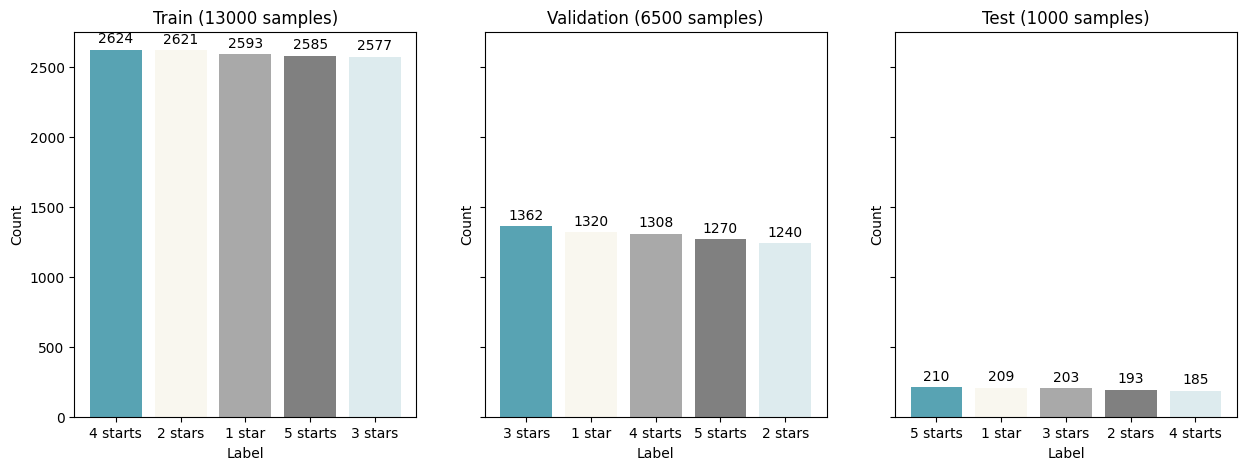

In [ ]:
label_map = {
    0: '1 star',
    1: '2 stars',
    2: '3 stars',
    3: '4 starts',
    4: '5 starts',
}

datasets = [yelp_train_df, yelp_val_df, yelp_test_df]
dataset_names = ["Train", "Validation", "Test"]

plot_dataset_distribution(datasets, dataset_names, label_map=label_map)


# Using Naïve Bayes classifier as baseline

Naive Bayes methods are a set of supervised learning algorithms often used for text classification, spam detection, and other similar tasks. These algorithms are based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable.

Bayes' theorem states the following relationship, given class variable \(y\) and dependent feature vector \(x_1\) through \(x_n\):

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) P(x_1, \ldots, x_n | y)}{P(x_1, \ldots, x_n)}
$$

Using the naive conditional independence assumption:

$$
P(x_i | y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n) = P(x_i | y),
$$

for all \(i\), this relationship is simplified to:

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) \prod_{i=1}^n P(x_i | y)}{P(x_1, \ldots, x_n)}
$$

Now let's consider the case where the feature vector consists of words $(w_1, w_2, w_3, \dots, w_n)$. The formula for the Naive Bayes method becomes:

\begin{align*}
\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(y \mid w_1, w_2, w_3, \dots, w_n\right) &=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \frac{P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y)}{P\left(w_1, w_2, w_3, \dots, w_n\right)} \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1 \mid y\right) \cdot \prod_{i=2}^n P\left(w_i \mid w_1, \dots, w_{i-1}, y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \prod_{i=1}^n P\left(w_i \mid y\right) \cdot P(y)
\end{align*}

In the second line, we remove the denominator $(P\left(w_1, w_2, w_3, \dots, w_n\right))$ as it's constant given the input. In the third line, we apply the chain rule of probability. Finally, in the fourth line, we use the naive conditional independence assumption to simplify the product of conditional probabilities.



In [ ]:

# Create the TfidfVectorizer and MultinomialNB pipeline
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
nb_pipeline.fit(yelp_train_df["text"], yelp_train_df["label"])

# Make predictions on the test dataset
test_predictions = nb_pipeline.predict(yelp_test_df["text"])


             Accuracy  F1 Score  1-Star F1  2-Star F1  3-Star F1
4-Star F1  \
Model
Naive Bayes     0.485  0.484025   0.666667   0.457983   0.392947
0.431472

             5-Star F1
Model
Naive Bayes   0.460526
Classification Report:
              precision    recall  f1-score   support

      1-Star       0.65      0.68      0.67       209
      2-Star       0.39      0.56      0.46       193
      3-Star       0.40      0.38      0.39       203
      4-Star       0.41      0.46      0.43       185
      5-Star       0.74      0.33      0.46       210

    accuracy                           0.48      1000
   macro avg       0.52      0.49      0.48      1000
weighted avg       0.52      0.48      0.48      1000



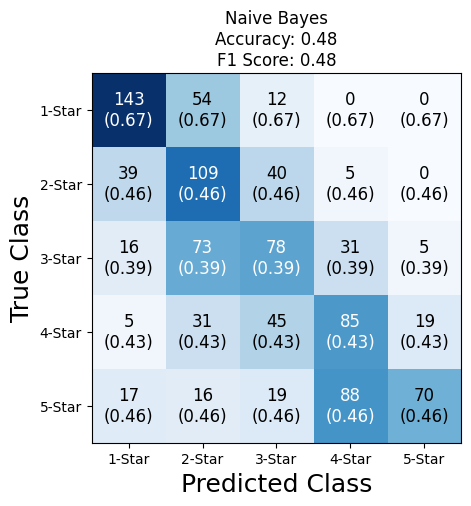

In [ ]:
true_labels = yelp_test_df["label"]
pred_labels = test_predictions
target_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
model_name = "Naive Bayes"

evaluation_df_bayes = create_evaluation_df_and_plot(true_labels, pred_labels, target_names, model_name)


# Fine-tune model

In this section of the Jupyter notebook, we are setting up a pipeline for training a text classification model using the RoBERTa model from Hugging Face's transformers library. The task is to classify the Yelp review texts into predefined categories.

First, we load the RoBERTa tokenizer and model. We are using the roberta-base variant of the model. The model is a sequence classification model, suitable for our task of text classification. We set the number of labels equal to the number of unique categories in our Yelp review dataset.

Next, we define the maximum sequence length and batch size. The sequence length is the maximum number of tokens that the model can handle, and the batch size is the number of examples to process at once during training. These are hyperparameters that can be tuned to optimize performance.

We then create Dataset objects for the training and validation sets using the dataset provided. These Dataset objects will be used to feed data into the model during training and evaluation.

The EarlyStoppingCallback is set up to monitor the validation loss during training and stop the training process if it doesn't see significant improvement for a certain number of consecutive epochs. This helps to prevent overfitting.

The TrainingArguments class is used to set various parameters for the training process, such as the number of epochs, the learning rate, and the batch size. We also specify that we want to save the model that achieves the best performance on the validation set.

Finally, we initialize a Trainer object with our model, the training arguments, the training and validation datasets, and the compute_metrics function for evaluating performance during training. We also add the early stopping callback to the Trainer. The Trainer is then used to train the model. After training, the model that achieved the best performance on the validation set is loaded, ready for evaluation.


## Prepare dataset

In [ ]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the RoBERTa model with `ignore_mismatched_sizes=True`
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

In [ ]:
# Define the maximum sequence length and batch size
max_length = 128
batch_size = 16
 
# Create the training, validation, and test datasets
train_dataset = TextClassificationDataset(yelp_train, tokenizer, max_length)
val_dataset = TextClassificationDataset(yelp_val, tokenizer, max_length)
test_dataset = TextClassificationDataset(yelp_test, tokenizer, max_length)


In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Stop training if the metric doesn't improve for 5 epochs
    early_stopping_threshold=1e-4,  # Minimum change in the monitored metric to be considered as an improvement
)


In [ ]:
from typing import Dict, Union, Any
from torch import nn
from transformers import Trainer
from transformers import PreTrainedModel
from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_metric = float('-inf')

    def compute_loss(self, model: PreTrainedModel, inputs: Dict[str, Union[torch.Tensor, Any]], return_outputs=False) -> torch.Tensor:
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Use the CrossEntropyLoss with class weights
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        model.train()
        inputs = self._prepare_inputs(inputs)
        loss = self.compute_loss(model, inputs)
        loss = loss / self.args.gradient_accumulation_steps

        if self.args.fp16:
            self.scaler.scale(loss).backward()
        elif self.args.fp16_backend == "apex":
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.args.deepspeed is not None:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

    def training_epoch_end(self, outputs):
        if self.lr_scheduler.__class__.__name__ == "ReduceLROnPlateau":
            eval_metrics = self.evaluate()
            metric_to_check = eval_metrics["eval_accuracy"]

            # Check if the metric improved
            if metric_to_check > self.best_metric:
                self.best_metric = metric_to_check

            # Update the learning rate scheduler with the evaluation metric
            self.lr_scheduler.step(metric_to_check)
        else:
            super().training_epoch_end(outputs)


In [ ]:
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy="epoch",
    save_total_limit=2,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,  
    warmup_steps=500,
)

class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(training_args.device) 

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)


# Train the model
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 13000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2439
  Number of trainable parameters = 124649477


Epoch,Training Loss,Validation Loss,Accuracy
1,1.102700,1.048440,0.564462
2,0.854600,1.021290,0.562462
3,0.605300,1.037368,0.606154


***** Running Evaluation *****
  Num examples = 6500
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-813
Configuration saved in ./results/checkpoint-813/config.json
Model weights saved in ./results/checkpoint-813/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6500
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1626
Configuration saved in ./results/checkpoint-1626/config.json
Model weights saved in ./results/checkpoint-1626/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6500
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-2439
Configuration saved in ./results/checkpoint-2439/config.json
Model weights saved in ./results/checkpoint-2439/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-813] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1626 (score: 1.0212900638580322).


TrainOutput(global_step=2439, training_loss=0.8541967838501627, metrics={'train_runtime': 7748.0846, 'train_samples_per_second': 5.034, 'train_steps_per_second': 0.315, 'total_flos': 2565401889024000.0, 'train_loss': 0.8541967838501627, 'epoch': 3.0})

## Save fine-tuned model

In [ ]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_roberta")

Configuration saved in fine_tuned_roberta/config.json
Model weights saved in fine_tuned_roberta/pytorch_model.bin


## Evaluate fine-tuned model

loading configuration file fine_tuned_roberta/config.json
Model config RobertaConfig {
  "_name_or_path": "fine_tuned_roberta",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 5

                               Accuracy  F1 Score  1-Star F1  2-Star
F1  \
Model
Fine-tuned RoBERTa no weights      0.57  0.574591   0.583333
0.518519

                               3-Star F1  4-Star F1  5-Star F1
Model
Fine-tuned RoBERTa no weights   0.586066   0.478149   0.691293
Classification Report:
              precision    recall  f1-score   support

      1-Star     0.8835    0.4354    0.5833       209
      2-Star     0.4686    0.5803    0.5185       193
      3-Star     0.5018    0.7044    0.5861       203
      4-Star     0.4559    0.5027    0.4781       185
      5-Star     0.7751    0.6238    0.6913       210

    accuracy                         0.5700      1000
   macro avg     0.6170    0.5693    0.5715      1000
weighted avg     0.6241    0.5700    0.5746      1000



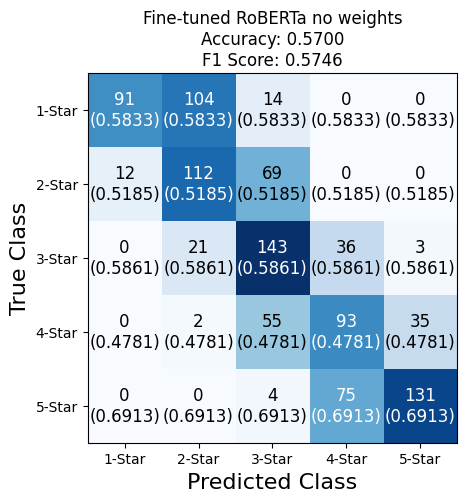

In [ ]:
target_names = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_roberta", num_labels=5)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
evaluation_df_yelp_roberta = evaluate_model(model, tokenizer, yelp_test, target_names, model_name="Fine-tuned RoBERTa no weights", is_dataframe=False)


In [ ]:
evaluation_df_yelp_all = evaluation_df_yelp_before._append(evaluation_df_yelp_roberta)
evaluation_df_yelp_all = evaluation_df_yelp_all._append(evaluation_df_bayes) 
evaluation_df_yelp_all


<ipython-input-30-c617515d829c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_yelp_all = evaluation_df_yelp_before.append(evaluation_df_yelp_roberta)
<ipython-input-30-c617515d829c>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_yelp_all = evaluation_df_yelp_all.append(evaluation_df_bayes)


,Accuracy,F1 Score,1-Star F1,2-Star F1,3-Star F1,4-Star F1,5-Star F1
Model,,,,,,,
BERT,0.270,0.151779,0.424779,0.060606,0.000000,0.148148,0.000000
RoBERTa,0.240,0.092903,0.387097,0.000000,0.000000,0.000000,0.000000
DistilBERT,0.140,0.050724,0.000000,0.068966,0.000000,0.000000,0.234234
DeBERTa,0.140,0.034386,0.000000,0.000000,0.000000,0.000000,0.245614
ALBERT,0.230,0.101684,0.000000,0.000000,0.105263,0.382609,0.000000
ELECTRA,0.210,0.091636,0.381818,0.000000,0.000000,0.000000,0.000000
Fine-tuned RoBERTa no weights,0.570,0.574591,0.583333,0.518519,0.586066,0.478149,0.691293
Naive Bayes,0.485,0.484025,0.666667,0.457983,0.392947,0.431472,0.460526
